Aim is to create a PMC model which can have more than one noise state, this will allow non-stationary noise to be handled
create signals, i.e. filtered noise, and normal sine wave,
create FHMM classifier which is able to deal with it

In [1]:
import sys

import spafe.utils.vis

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/fhmm_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [41]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from spafe.features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)
from scipy import signal
from scipy.stats import multivariate_normal as mvn

<Figure size 240x240 with 0 Axes>

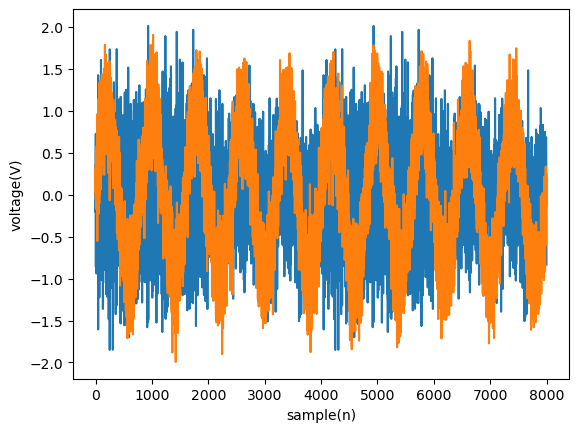

In [31]:
Fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)

n1 = np.random.normal(0, np.sqrt(0.1), sample)
n3 = np.random.normal(0, np.sqrt(0.58), sample)

# lpf
sos = signal.butter(10, 1500, 'lp', fs=Fs, output='sos')
n3_lpf = signal.sosfilt(sos, n3)

# hpf
sos = signal.butter(10, 1500, 'hp', fs=Fs, output='sos')
n3_hpf = signal.sosfilt(sos, n3)

# combine
noise_combined = np.append(n3_hpf[0:2000], n3_lpf[0:2000])
noise_combined = np.append(noise_combined, noise_combined)

s1 = np.sin(np.pi * f1 * x / Fs) + n1

s2 = noise_combined
plt.plot(x, s2)
plt.plot(x, s1)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

0.2918268678938297


7.6342799356293725

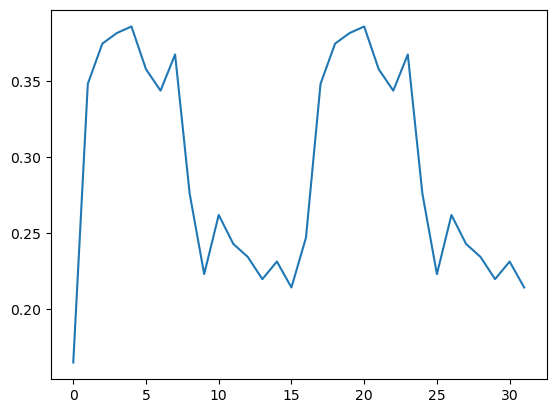

In [33]:
# snr before normalisation
ap = utils.periodic_power(s2, 500, 250)
plt.plot(ap)
print(np.mean(ap))
s1_ap = 0.58
s2_ap = 0.30
snr = 10 * np.log10(s1_ap / s2_ap)
snr

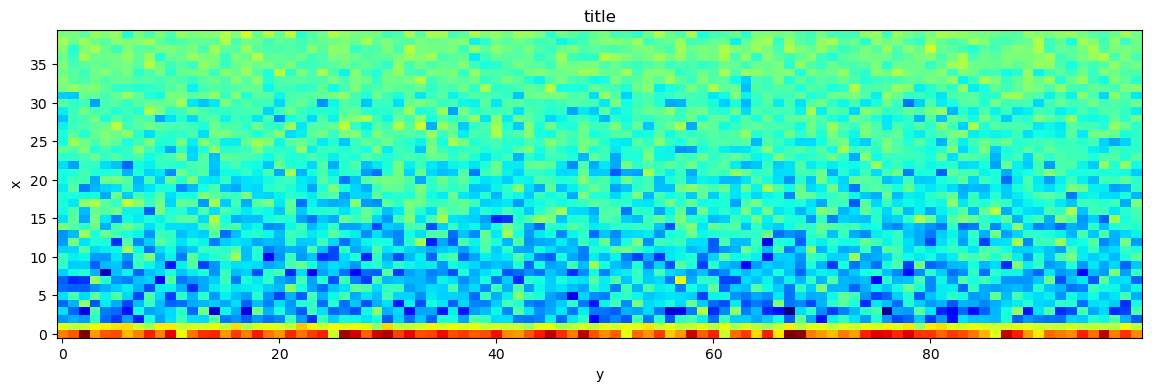

In [42]:
s1_feat = np.log(mfcc.mel_spectrogram(sig=s1, fs=8000, nfilts=40)[0])
s1_hmm = hmm.GaussianHMM(1)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

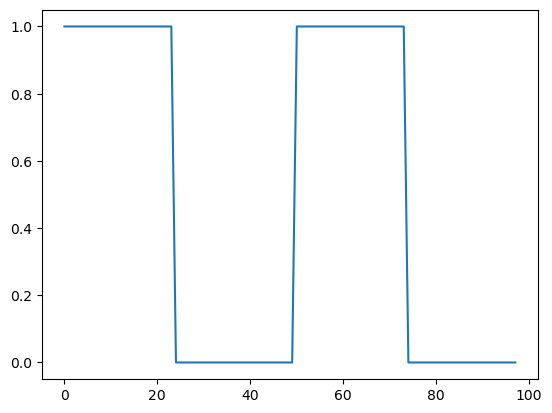

In [43]:
s2_feat = np.log(mfcc.mel_spectrogram(sig=s2, fs=8000, nfilts=40)[0])
s2_hmm = hmm.GaussianHMM(2)
s2_hmm.fit(s2_feat)
_, ss = s2_hmm.decode(s2_feat)
# s2_hmm_sampled, _ = s2_hmm.sample(100)
# vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')
plt.plot(ss)


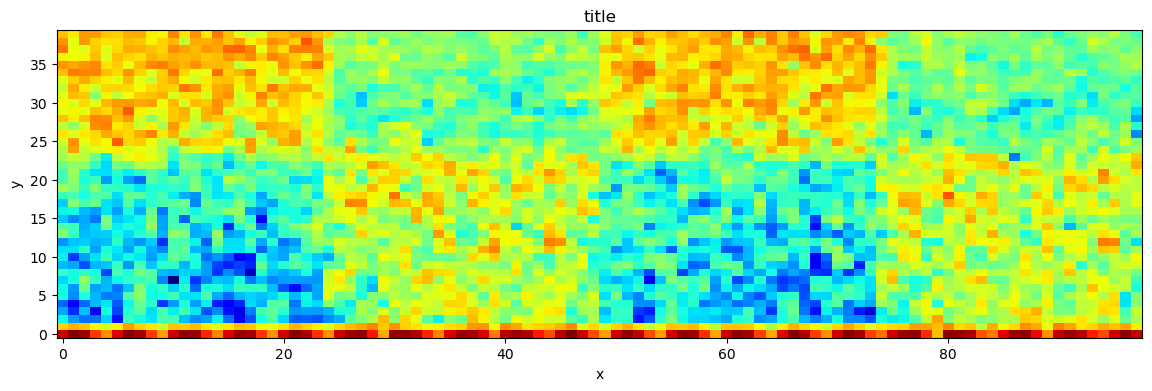

In [45]:
s3 = s1 + s2
s3_features = np.log(mfcc.mel_spectrogram(sig=s3, fs=8000, nfilts=40)[0])

In [47]:
def get_params(hmm01):
    if isinstance(hmm01, hmm.GaussianHMM):
        print('hmm learn object')
        return hmm01.transmat_, hmm01.n_components, hmm01.means_, hmm01.covars_, hmm01.startprob_

def get_m_and_c(j,k, m1, m2):
    mean_j = m1.means_[j]
    mean_k = m2.means_[k]
    m = np.maximum(mean_j, mean_k)
    m_mask = (mean_j > mean_k)
    covar_j = np.diag(m1.covars_[j])
    covar_k = np.diag(m2.covars_[k])
    c = np.where(m_mask, covar_j, covar_k)
    return m, np.diag(c)

def get_prob_matrix(model01:hmm.GaussianHMM, model02:hmm.GaussianHMM, some_features):
    states01 = model01.n_components
    states02 = model02.n_components
    T_len = len(some_features)

    states_dict = {}
    logBjk = np.zeros((states01, states02, T_len))
    for j in range(states01):
        for k in range(states02):
            m, c = get_m_and_c(j, k, model01, model02) # combine m and c for models
            for t in range(T_len):
                p = mvn.logpdf(some_features[t], m, c)
                logBjk[j, k, t] += p
            states_dict[(j*states01 + k)] = [j, k]

    # print(np.concatenate(logBjk, axis = 0), 'logbjk')

    return np.concatenate(logBjk, axis = 0), states_dict

def kronecker_list(list_A):
    '''
    Input: list_pi: List of PI's of individual learnt HMMs
    Output: Combined Pi for the FHMM
    '''
    result=list_A[0]
    for i in range(len(list_A)-1):
        result=np.kron(result,list_A[i+1])
    return result

def viterbi_algorithm_parallel(features, hmm01: hmm.GaussianHMM, hmm02: hmm.GaussianHMM):
    # returns the most likely state sequence given observed sequence x for fhmm of hmm01 and hmm02
    # assume features are log - power and therefore max mean is used per state
    # using the Viterbi algorithm

    T = len(features)
    a_01, n01, m01, c01, pi01 = get_params(hmm01)
    a_02, n02, m02, c02, pi02 = get_params(hmm02)

    # make the emission matrix B
    logB, states_dict = get_prob_matrix(hmm01, hmm02, features)  # i x (j x t) matrix of observations evaluated at pdf of states
    t_states = len(states_dict)

    # init delta and psi
    delta = np.zeros((T, t_states))
    psi = np.zeros((T, t_states))

    # get combined pi and a
    pi_combined = kronecker_list([pi01, pi02])

    pi_combined = pi_combined + 1e-10
    pi_combined /= pi_combined.sum()

    a_combined = kronecker_list([a_01, a_02])


    # compute first row of delta
    for x in range(t_states):
        delta[0, x] = np.log(pi_combined[x]) + logB[x, 0]

    for t in range(1, T):
        for x in range(t_states):
            ao1_row = a_combined[:, x]
            next_delta = delta[t - 1] + np.log(ao1_row)
            delta[t, x] = np.max(next_delta) + logB[x, t]
            psi[t, x] = np.argmax(next_delta)

    # backtracks
    states_decoded = np.zeros(T, dtype=np.int32)
    states_decoded[T - 1] = np.argmax(delta[T - 1])
    for t in range(T - 2, -1, -1):
        states_decoded[t] = psi[t + 1, states_decoded[t + 1]]
    log_prob = delta[-1, states_decoded[-1]]

    # split into separate:

    ss01 = []
    ss02 = []
    for x in range(len(states_decoded)):
        temp = states_dict[states_decoded[x]]
        ss01.append(temp[0])
        ss02.append(temp[1])

    return log_prob, [ss01, ss02]


In [48]:
log_prob, [ss01, ss02] = viterbi_algorithm_parallel(s3_features, s1_hmm, s2_hmm)

hmm learn object
hmm learn object


-4299.284167359604 -12594.23095374523


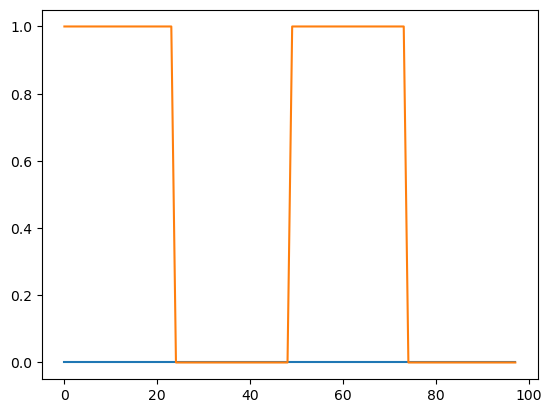

In [51]:
plt.plot(ss01)
plt.plot(ss02)
print(log_prob, s1_hmm.decode(s3_features)[0])